## Parks Data

### 1. Data Preprocessing

In [1]:
# Load list of relevant parks
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load overall park geoJSON file and adjust datetype of merge condition to integer
gjson_df = gpd.read_file('./data/parks.json')
gjson_df["idnr"] = gjson_df["idnr"].astype('int64')

# Load list of relevant park ids
df = pd.read_csv('./data/relevant_ids.csv', sep = ';')

<AxesSubplot: >

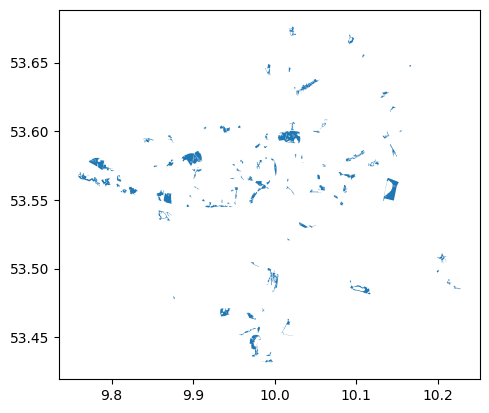

In [3]:
# Merge both dataframes to have basic dataset of all relevant park polygons
merged_gdf = gpd.GeoDataFrame(gjson_df.merge(df, on='idnr'))

# Plotting of parks
merged_gdf.plot()

In [4]:
# build new geopandas dataframe with only relevant columns
# rename columns and change datatypes
gdf = merged_gdf[['benennung_y', 'flaeche_ha_y', 'geometry']]
gdf = gdf.rename(columns={'benennung_y': 'name', 'flaeche_ha_y': 'size'})
gdf["size"] = gdf["size"].astype('float')
gdf.dtypes

name          object
size         float64
geometry    geometry
dtype: object

In [5]:
# merge multiple park and playground spaces per park, resulting in one geometry per park
merged_parks_gdf = gdf.dissolve(by='name', aggfunc={'size': 'sum'}).reset_index()

### 2. Add Centroid

In [6]:
# add representative point and centroid per park
merged_parks_gdf['representative_point'] = merged_parks_gdf.representative_point()
merged_parks_gdf ['centroid'] = merged_parks_gdf['geometry'].centroid

C:\Users\nico-\AppData\Local\Temp\ipykernel_9772\163508999.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_parks_gdf ['centroid'] = merged_parks_gdf['geometry'].centroid


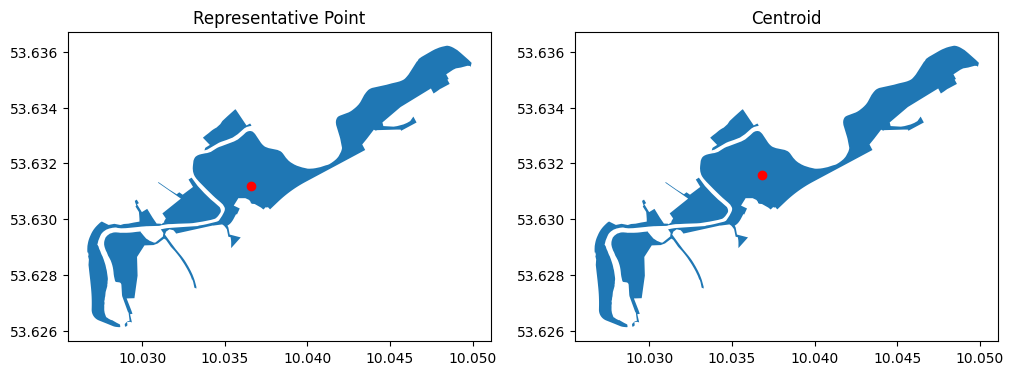

In [7]:
# Testing both alternatives
park_name = "Alsterpark Klein Borstel"

def centroid_comparison(park_name):
    park_comparison_df = merged_parks_gdf.query(f'name == "{park_name}"')
    
    rep_comparison_df = park_comparison_df["representative_point"]
    centroid_comparison_df = park_comparison_df["centroid"]

    # Plotting of both alternatives for comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    park_comparison_df.plot(ax=axes[0])
    rep_comparison_df.plot(ax=axes[0], marker='o', color='red')

    park_comparison_df.plot(ax=axes[1])
    centroid_comparison_df.plot(ax=axes[1], marker='o', color='red')

    axes[0].set_title('Representative Point')
    axes[1].set_title('Centroid')

    plt.show()

centroid_comparison(park_name)

In [8]:
merged_parks_gdf.tail(60)

,name,geometry,size,representative_point,centroid
63,Jenfelder Moorpark,"MULTIPOLYGON (((10.12675 53.57701, 10.12678 53...",12.4358,POINT (10.12542 53.57660),POINT (10.12191 53.57643)
64,Jenischpark,"POLYGON ((9.87097 53.55465, 9.87109 53.55453, ...",41.9783,POINT (9.86866 53.55102),POINT (9.86902 53.55113)
65,Johannes-Prassek-Park,"POLYGON ((10.02635 53.58174, 10.02635 53.58174...",2.0396,POINT (10.02574 53.58210),POINT (10.02568 53.58226)
66,Jugendpark Langenhorn,"MULTIPOLYGON (((9.99447 53.64146, 9.99448 53.6...",12.6744,POINT (9.99308 53.64735),POINT (9.99276 53.64521)
67,Kapitaen-Schroeder-Park,"POLYGON ((9.95231 53.54686, 9.95231 53.54684, ...",1.2974,POINT (9.95098 53.54810),POINT (9.95158 53.54765)
68,Kellinghusens Park,"POLYGON ((9.99031 53.58879, 9.99025 53.58882, ...",2.4262,POINT (9.98837 53.58855),POINT (9.98867 53.58857)
69,Kleine Wallanlagen,"POLYGON ((9.98137 53.55843, 9.98138 53.55843, ...",3.7430,POINT (9.98083 53.55724),POINT (9.98103 53.55745)
70,Langenbeker Feld,"POLYGON ((9.99757 53.43243, 9.99767 53.43219, ...",7.7433,POINT (9.99445 53.43283),POINT (9.99296 53.43259)
71,Liliencronpark,"MULTIPOLYGON (((10.15453 53.59980, 10.15460 53...",1.2786,POINT (10.15463 53.60013),POINT (10.15452 53.60012)
72,Lindenpark,"MULTIPOLYGON (((9.96125 53.56471, 9.96121 53.5...",1.8531,POINT (9.95954 53.56642),POINT (9.95992 53.56615)


In [9]:
park_size = merged_parks_gdf[['name','size']]
park_size_cluster = park_size.sort_values(by='size', ascending= False)
park_size_cluster['size_sqm'] = park_size_cluster['size']*10000
merged_parks_gdf.head()


,name,geometry,size,representative_point,centroid
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5...",1.6005,POINT (9.94847 53.56571),POINT (9.94810 53.56558)
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53...",27.2419,POINT (10.03659 53.63119),POINT (10.03683 53.63159)
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53...",13.7983,POINT (10.00115 53.57361),POINT (10.00090 53.57318)
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ...",7.9442,POINT (9.98665 53.55934),POINT (9.98664 53.55931)
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5...",5.0377,POINT (9.97118 53.54874),POINT (9.97132 53.54883)


In [10]:
park_size_cluster.dtypes

name         object
size        float64
size_sqm    float64
dtype: object

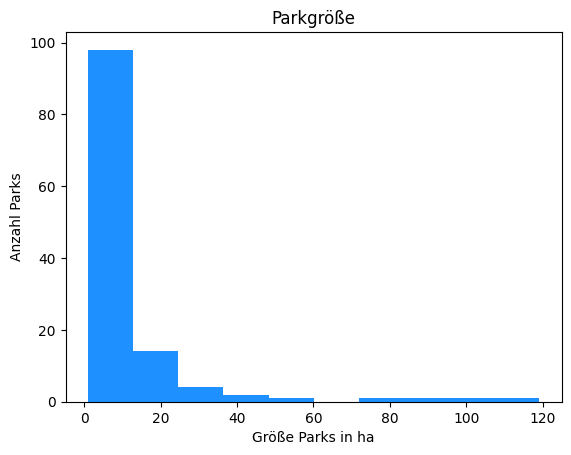

In [11]:
f, ax = plt.subplots(1,1)
plt.hist(park_size_cluster['size'],bins=10, color = 'dodgerblue')

ax.set_title('Parkgröße')
ax.set_xlabel('Größe Parks in ha')
ax.set_ylabel('Anzahl Parks')

plt.show()

In [12]:
conditions = [
    (merged_parks_gdf['size'] < 10.0),
    (merged_parks_gdf['size'] > 10.0) & (merged_parks_gdf['size'] <= 60.0),
    (merged_parks_gdf['size'] > 60.0)
]

values = ['500','1000','1500']

merged_parks_gdf['walk_dist'] = np.select(conditions,values)
merged_parks_gdf.head()

,name,geometry,size,representative_point,centroid,walk_dist
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5...",1.6005,POINT (9.94847 53.56571),POINT (9.94810 53.56558),500
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53...",27.2419,POINT (10.03659 53.63119),POINT (10.03683 53.63159),1000
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53...",13.7983,POINT (10.00115 53.57361),POINT (10.00090 53.57318),1000
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ...",7.9442,POINT (9.98665 53.55934),POINT (9.98664 53.55931),500
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5...",5.0377,POINT (9.97118 53.54874),POINT (9.97132 53.54883),500


In [13]:
park_coordinates = merged_parks_gdf[["name", "geometry"]]
park_coordinates.head()

,name,geometry
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5..."
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53..."
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53..."
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ..."
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5..."


In [14]:
park_distances = merged_parks_gdf[["name", "walk_dist"]]
park_distances.head()

,name,walk_dist
0,Alsenpark,500
1,Alsterpark Klein Borstel,1000
2,Alstervorland,1000
3,Alter Botanischer Garten,500
4,Alter Elbpark,500


In [15]:
park_centroids = merged_parks_gdf[["name","centroid", "walk_dist"]]
park_centroids['lat'] = park_centroids.centroid.y
park_centroids['long'] = park_centroids.centroid.x
park_centroids = park_centroids.drop(columns = 'centroid')
park_centroids.head()

c:\Users\nico-\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\nico-\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,name,walk_dist,lat,long
0,Alsenpark,500,53.565584,9.948098
1,Alsterpark Klein Borstel,1000,53.631590,10.036828
2,Alstervorland,1000,53.573183,10.000896
3,Alter Botanischer Garten,500,53.559310,9.986637
4,Alter Elbpark,500,53.548831,9.971316


In [18]:

park_size = merged_parks_gdf[["name","size","walk_dist"]]
park_size = park_size.drop(park_size[park_size.name == 'Oejendorfer Park'].index)
park_size = park_size.drop(park_size[park_size.name == 'oejendorfer Park'].index)
park_size = park_size.drop(park_size[park_size.name == 'Stadtpark'].index)
park_size = park_size.drop(park_size[park_size.name == 'Altonaer Volkspark'].index)
park_size = park_size.drop(park_size[park_size.name == 'Waldpark Marienhoehe'].index)
park_size

,name,size,walk_dist
0,Alsenpark,1.6005,500
1,Alsterpark Klein Borstel,27.2419,1000
2,Alstervorland,13.7983,1000
3,Alter Botanischer Garten,7.9442,500
4,Alter Elbpark,5.0377,500
...,...,...,...
117,Wehbers Park,3.1201,500
118,Wesselhoeftpark,4.6759,500
119,Westerpark,15.5176,1000
120,Wilhelmsburger Inselpark,45.3670,1000


In [27]:
park_centroids.to_json('centroid_data.json', indent=2, orient ='index')

In [17]:
park_size.to_json('park_size_data.json', indent=2, orient ='index')

In [61]:
park_coordinates.to_file('data.json', driver ='GeoJSON')

In [62]:
park_distances.to_json('distance_data.json', indent=2, orient ='index')